# Introduction
This is the random forest learner associated with Voter Analysis.
Please be sure to run DataCleaning.ipynb first to prepare the data

This notebook based on Fastai V1 ML course

## Imports
Import libraries and write settings here.

In [345]:
from fastai.tabular import *
from fastai import *

# Data manipulation
import pandas as pd
import numpy as np

# Options for pandas
pd.options.display.max_columns = 60
pd.options.display.max_rows = 60

# Display all cell outputs
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = 'all'

from IPython import get_ipython
ipython = get_ipython()

# autoreload extension
if 'autoreload' not in ipython.extension_manager.loaded:
    %load_ext autoreload

%autoreload 2

# Visualizations
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import iplot, init_notebook_mode
init_notebook_mode(connected=True)

import cufflinks as cf
cf.go_offline(connected=True)
cf.set_config_file(theme='white')

# Load train/test
If either of the following fail then please be sure to run DataCleaning.ipynb first to prepare the data

In [346]:
# first column in each file is the dependent variable, the rest are independant
csv_files=['vote12gop','TrumpGEVote','TrumpPVote']

whichfle=2
fn = csv_files[whichfle]

trnfile = 'tmp/' + fn +'_train'
tstfile = 'tmp/' + fn +'_tst'
jsonfile = 'tmp/' + fn + '_catcont.json'

outdir = 'outBElectionResultsPermuted'
filename='results.csv'
filename_all = 'results_complete.csv'
filename_model_params = "RF_model_params.sav"
os.makedirs(outdir, exist_ok=True)

In [347]:
trnfile

'tmp/TrumpPVote_train'

In [348]:
#get processed training and test data
trn_raw = pd.read_feather(trnfile)
tst_raw = pd.read_feather(tstfile)

trn = trn_raw.copy()
tst = tst_raw.copy()

# columns_dep_var= 'cc.vote16'

In [349]:
trn_raw.head()

,index,cc.trumppvote,cc.age,cc.blackdum,cc.cc16_304,cc.cc16_305_2,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.catholic,cc.evanprot,cc.ideo7,cc.inddum,cc.religiosity,cc.repdum,cc.sex,cc.whitedum,cc.emp.nojob,cc.faminc,cc.i.white.educhs,cc.immviewsum,cc.maxeduc.4yr,cc.union,crashpc,demo.popdense,job.uer,mort.ucd.despair.disc95.pdpy,rustpc
0,10476,0,0.965457,0,0.947973,0,0.517074,0.329550,0.818020,0.386066,0,0,0.451077,0,0.814553,0,0,1,0,1.264915,0,0.000000,0,1,0.355196,0.124574,0.811116,1.392480,0.417110
1,21132,0,1.201895,0,0.631982,1,0.517074,0.659101,1.227029,0.772133,0,0,0.225539,0,0.362024,0,0,1,0,1.686553,0,0.425285,0,1,0.933311,0.356074,0.913419,0.910270,0.600250
2,7689,1,1.241301,0,1.579954,0,1.551223,1.647751,1.636039,1.930331,1,0,1.353232,0,1.538600,1,0,1,0,0.281092,0,1.701138,0,0,0.543310,0.044815,1.070528,0.781661,0.000000
3,19541,0,0.729018,1,1.579954,0,0.517074,0.329550,0.409010,0.386066,0,0,1.578771,0,0.814553,0,1,0,0,0.562184,0,0.425285,0,0,0.746677,0.153367,1.002935,1.010251,0.869757
4,10267,0,1.103379,0,0.947973,0,0.517074,0.659101,0.818020,1.930331,1,0,1.578771,0,0.543035,1,1,1,0,0.843277,1,1.701138,0,0,2.122966,0.000300,0.281333,0.499205,0.546736


## Get the original indexes of train and tst
Use these to merge results back to original dataset

In [350]:
trn_indexes = trn_raw[['index']].copy()
tst_indexes = tst_raw[['index']].copy()

In [351]:
#delete the index column from trn and tst
trn_raw =trn_raw.drop('index',axis=1)
tst_raw =tst_raw.drop('index',axis=1)

In [352]:
all_indexes = trn_indexes.copy().append(tst_indexes.copy(), ignore_index=True)
print(f"Have {len(trn_indexes)} train, {len(tst_indexes)} test, {len(all_indexes)}")

Have 24716 train, 2747 test, 27463


In [353]:
type(all_indexes)

pandas.core.frame.DataFrame

In [354]:
type(all_indexes)

pandas.core.frame.DataFrame

In [355]:
trn_raw.head()
tst_raw.head()

,cc.trumppvote,cc.age,cc.blackdum,cc.cc16_304,cc.cc16_305_2,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.catholic,cc.evanprot,cc.ideo7,cc.inddum,cc.religiosity,cc.repdum,cc.sex,cc.whitedum,cc.emp.nojob,cc.faminc,cc.i.white.educhs,cc.immviewsum,cc.maxeduc.4yr,cc.union,crashpc,demo.popdense,job.uer,mort.ucd.despair.disc95.pdpy,rustpc
0,0,0.965457,0,0.947973,0,0.517074,0.329550,0.818020,0.386066,0,0,0.451077,0,0.814553,0,0,1,0,1.264915,0,0.000000,0,1,0.355196,0.124574,0.811116,1.392480,0.417110
1,0,1.201895,0,0.631982,1,0.517074,0.659101,1.227029,0.772133,0,0,0.225539,0,0.362024,0,0,1,0,1.686553,0,0.425285,0,1,0.933311,0.356074,0.913419,0.910270,0.600250
2,1,1.241301,0,1.579954,0,1.551223,1.647751,1.636039,1.930331,1,0,1.353232,0,1.538600,1,0,1,0,0.281092,0,1.701138,0,0,0.543310,0.044815,1.070528,0.781661,0.000000
3,0,0.729018,1,1.579954,0,0.517074,0.329550,0.409010,0.386066,0,0,1.578771,0,0.814553,0,1,0,0,0.562184,0,0.425285,0,0,0.746677,0.153367,1.002935,1.010251,0.869757
4,0,1.103379,0,0.947973,0,0.517074,0.659101,0.818020,1.930331,1,0,1.578771,0,0.543035,1,1,1,0,0.843277,1,1.701138,0,0,2.122966,0.000300,0.281333,0.499205,0.546736


,cc.trumppvote,cc.age,cc.blackdum,cc.cc16_304,cc.cc16_305_2,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.catholic,cc.evanprot,cc.ideo7,cc.inddum,cc.religiosity,cc.repdum,cc.sex,cc.whitedum,cc.emp.nojob,cc.faminc,cc.i.white.educhs,cc.immviewsum,cc.maxeduc.4yr,cc.union,crashpc,demo.popdense,job.uer,mort.ucd.despair.disc95.pdpy,rustpc
0,0,0.709315,0,0.631982,0,1.551223,0.329550,1.636039,0.386066,0,0,0.451077,0,0.362024,0,1,1,0,0.562184,1,0.000000,0,0,0.981322,0.015040,1.238597,0.918803,0.458212
1,0,0.788128,0,0.947973,0,0.517074,0.659101,1.227029,0.772133,0,0,0.902155,1,0.452529,0,1,1,0,1.264915,0,0.000000,1,0,0.696811,0.064986,0.706987,0.600396,1.260658
2,0,1.103379,0,0.947973,0,0.517074,0.659101,0.409010,0.386066,1,0,0.225539,0,0.814553,0,1,1,0,0.702731,0,0.000000,1,1,0.357314,0.191659,0.738043,0.859472,0.462104
3,0,1.320114,0,0.947973,0,0.517074,0.329550,1.636039,0.772133,0,0,0.676616,0,0.271518,0,1,1,0,0.421638,1,0.425285,0,1,0.471241,0.083311,0.538917,0.797814,0.757643
4,0,1.438333,0,0.631982,0,0.517074,0.329550,0.818020,0.772133,0,0,0.902155,0,0.362024,0,0,1,0,0.843277,0,0.000000,0,1,0.402034,0.174046,1.165523,0.943574,0.296608


## Get continuous and categorical variables, convert dependant variable to int64

In [356]:
#get continuous and categorical variables
with open(jsonfile) as f:
    data1 = json.load(f)
    res_cont = data1[0]
    res_cat = data1[1] 
    columns_dep_var = data1[2]
   
# res_cont
# res_cat

In [357]:
columns_dep_var

'cc.trumppvote'

In [358]:
#remove the dependant variable
res_cont = [x for x in res_cont if x not in columns_dep_var]
res_cat = [x for x in res_cat if x not in columns_dep_var]

In [359]:
#convert trumpgevote to long (otherwise fit fails)
trn[columns_dep_var] = trn[columns_dep_var].astype('int64');
tst[columns_dep_var] = tst[columns_dep_var].astype('int64');

print(str(len(trn)))
print(str(len(tst)))

24716
2747


## Lets see what features are corelated with each other

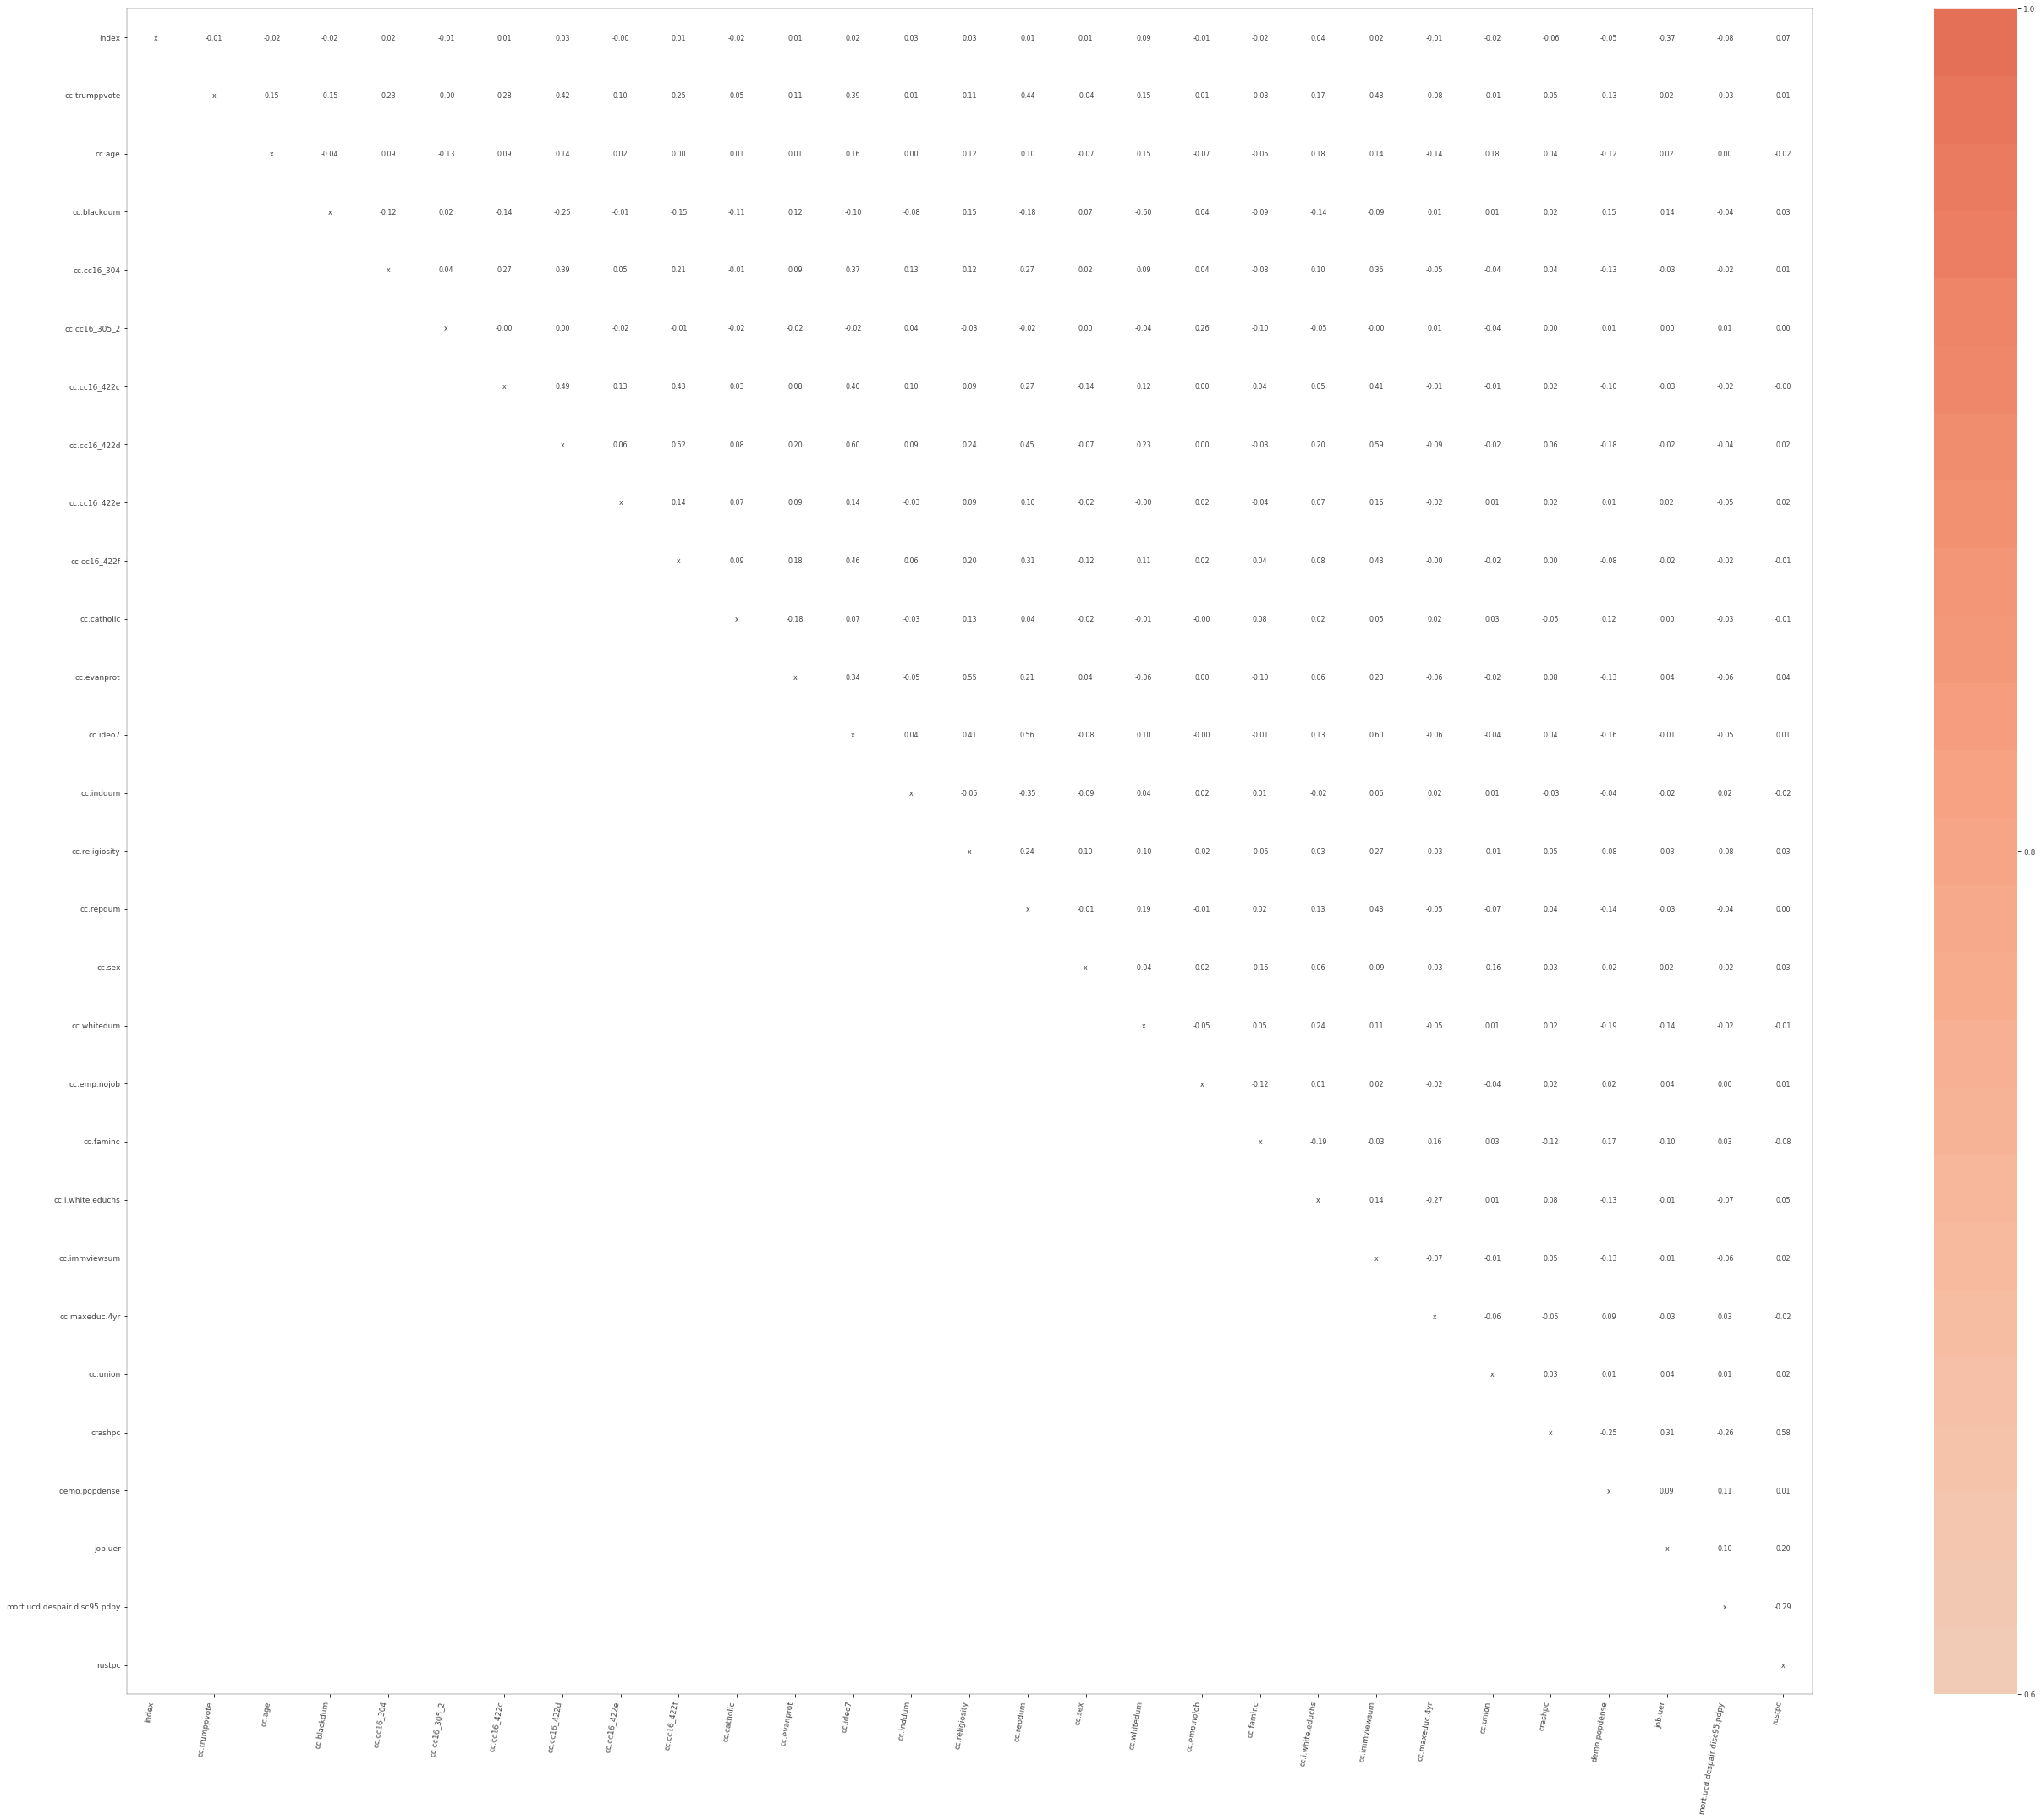

In [360]:
from rfpimp import plot_corr_heatmap
viz = plot_corr_heatmap(trn, figsize=(50,30))
viz.view()

## Categorify and Fill Missing

In [361]:
#from docs https://docs.fast.ai/tabular.transform.html
tfm = Categorify(cat_names=res_cat, cont_names=res_cont)
tfm(trn)
tfm(tst)

In [362]:
#just checking to see if it works on any old variable
trn[res_cat[0]].cat.categories
tst[res_cat[0]].cat.categories

Int64Index([0, 1], dtype='int64')

Int64Index([0, 1], dtype='int64')

In [363]:
tfm1 = FillMissing(cat_names=res_cat, cont_names=res_cont, add_col=False)
tfm1(trn)
tfm1(tst)

## Clean up any missing columns that result from unfortunate test selection

In [364]:
trn_y=trn[columns_dep_var].copy()
trn=trn.drop(columns_dep_var,axis=1)

tst_y=tst[columns_dep_var].copy()
tst=tst.drop(columns_dep_var,axis=1)

# trn.T
# trn_y

In [365]:
#You cannot have any Nan (missing data) fields or random forest will not work.
print(f"Total trn columns = {len(trn.columns)}, total tst columns = {len(tst.columns)}") 
print(f"Total trn columns with Nans= {len(trn.columns[trn.isnull().any()])}") #add ~ to get columns with no missing values
print(f"Total tst columns with Nans= {len(tst.columns[tst.isnull().any()])}") #add ~ to get columns with no missing values

Total trn columns = 28, total tst columns = 28
Total trn columns with Nans= 0
Total tst columns with Nans= 0


In [366]:
#hmmm if either has 1 more column than train then see what it is
set(tst.columns)-set(trn.columns)
set(trn.columns)-set(tst.columns)

#missing one of the _na columns.  This is added, and set to 1, when a variable has an NaN value to mark
#columns that have NaNs

#find the index of the column in trn
# idx=trn.columns.tolist().index('cc.catholic_na')
# idx
# type(trn.columns)

# tst.insert(loc=idx, column='cc.catholic_na', value=False)

set()

set()

# Train a RandomForest on all data

In [367]:
trn.head().columns

Index(['index', 'cc.age', 'cc.blackdum', 'cc.cc16_304', 'cc.cc16_305_2',
       'cc.cc16_422c', 'cc.cc16_422d', 'cc.cc16_422e', 'cc.cc16_422f',
       'cc.catholic', 'cc.evanprot', 'cc.ideo7', 'cc.inddum', 'cc.religiosity',
       'cc.repdum', 'cc.sex', 'cc.whitedum', 'cc.emp.nojob', 'cc.faminc',
       'cc.i.white.educhs', 'cc.immviewsum', 'cc.maxeduc.4yr', 'cc.union',
       'crashpc', 'demo.popdense', 'job.uer', 'mort.ucd.despair.disc95.pdpy',
       'rustpc'],
      dtype='object')

In [368]:
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

#create a random forest object
m_rf = RandomForestClassifier(n_estimators=100, n_jobs=-1, oob_score=True, max_features='auto', min_samples_leaf=10)

In [369]:

def rmse(x,y): 
    '''this and R**2 used for continuous variables'''
    return math.sqrt(((x-y)**2).mean())

def print_score(m, trn, trn_y, tst, tst_y):
    '''
    
    '''
    res = [m.score(trn, trn_y), m.score(tst, tst_y)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

In [370]:
#train the random forest 
m_rf.fit(trn.iloc[:,1:], trn_y)

print_score(m_rf, trn.iloc[:,1:], trn_y, tst.iloc[:,1:], tst_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=True, random_state=None, verbose=0, warm_start=False)

[0.902047256837676, 0.8380050964688751, 0.8252144359928791]


In [371]:
# len(trn.columns)#28
trn.columns

Index(['index', 'cc.age', 'cc.blackdum', 'cc.cc16_304', 'cc.cc16_305_2',
       'cc.cc16_422c', 'cc.cc16_422d', 'cc.cc16_422e', 'cc.cc16_422f',
       'cc.catholic', 'cc.evanprot', 'cc.ideo7', 'cc.inddum', 'cc.religiosity',
       'cc.repdum', 'cc.sex', 'cc.whitedum', 'cc.emp.nojob', 'cc.faminc',
       'cc.i.white.educhs', 'cc.immviewsum', 'cc.maxeduc.4yr', 'cc.union',
       'crashpc', 'demo.popdense', 'job.uer', 'mort.ucd.despair.disc95.pdpy',
       'rustpc'],
      dtype='object')

# Test the model on test data

In [372]:
# len(tst.columns)

In [373]:
def eval_accuracy(preds,targs, silent=True):
    totals = len(preds)
    matches = 0
    for x in zip(preds,targs):
        if x[0]==x[1]:
            matches+=1
    acc=100*matches/totals 
    if( silent == False):
        print(f"Got {matches} right out of {totals} samples, Accuracy is {acc} percent")
    return acc

In [374]:
preds1 = m_rf.predict(tst.iloc[:,1:])

eval_accuracy(preds1,tst_y,silent=False);

Got 2302 right out of 2747 samples, Accuracy is 83.80050964688752 percent


## Save this model for later

In [375]:
# save the model to disk
pickle.dump(m_rf, open(outdir+"/"+filename_model_params, 'wb'))
 
# load the model from disk
m_rf = pickle.load(open(outdir+"/"+filename_model_params, 'rb'))

# Now that we have a fully trained model (mod_rf  from above) lets see what it  predicts when we permute the input data

Assuming the model has learned a good bit about how people vote. Lets change the inputs and see what it says.

In [376]:
#first lets append train and test together, note, these will be in a different order than original train test set
all = trn.copy().append(tst.copy(), ignore_index=True)
all_y = trn_y.copy().append(tst_y.copy(), ignore_index=True)
all_indexes = trn_indexes.copy().append(tst_indexes.copy(), ignore_index=True)

#lets put the original predictions back
all.insert(0,columns_dep_var,all_y)
all.head()
len(all)
all_indexes.head()
trn.head()

,cc.trumppvote,index,cc.age,cc.blackdum,cc.cc16_304,cc.cc16_305_2,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.catholic,cc.evanprot,cc.ideo7,cc.inddum,cc.religiosity,cc.repdum,cc.sex,cc.whitedum,cc.emp.nojob,cc.faminc,cc.i.white.educhs,cc.immviewsum,cc.maxeduc.4yr,cc.union,crashpc,demo.popdense,job.uer,mort.ucd.despair.disc95.pdpy,rustpc
0,0,10476,0.965457,0,0.947973,0,0.517074,0.329550,0.818020,0.386066,0,0,0.451077,0,0.814553,0,0,1,0,1.264915,0,0.000000,0,1,0.355196,0.124574,0.811116,1.392480,0.417110
1,0,21132,1.201895,0,0.631982,1,0.517074,0.659101,1.227029,0.772133,0,0,0.225539,0,0.362024,0,0,1,0,1.686553,0,0.425285,0,1,0.933311,0.356074,0.913419,0.910270,0.600250
2,1,7689,1.241301,0,1.579954,0,1.551223,1.647751,1.636039,1.930331,1,0,1.353232,0,1.538600,1,0,1,0,0.281092,0,1.701138,0,0,0.543310,0.044815,1.070528,0.781661,0.000000
3,0,19541,0.729018,1,1.579954,0,0.517074,0.329550,0.409010,0.386066,0,0,1.578771,0,0.814553,0,1,0,0,0.562184,0,0.425285,0,0,0.746677,0.153367,1.002935,1.010251,0.869757
4,0,10267,1.103379,0,0.947973,0,0.517074,0.659101,0.818020,1.930331,1,0,1.578771,0,0.543035,1,1,1,0,0.843277,1,1.701138,0,0,2.122966,0.000300,0.281333,0.499205,0.546736


27463

,index
0,10476
1,21132
2,7689
3,19541
4,10267


,index,cc.age,cc.blackdum,cc.cc16_304,cc.cc16_305_2,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.catholic,cc.evanprot,cc.ideo7,cc.inddum,cc.religiosity,cc.repdum,cc.sex,cc.whitedum,cc.emp.nojob,cc.faminc,cc.i.white.educhs,cc.immviewsum,cc.maxeduc.4yr,cc.union,crashpc,demo.popdense,job.uer,mort.ucd.despair.disc95.pdpy,rustpc
0,10476,0.965457,0,0.947973,0,0.517074,0.329550,0.818020,0.386066,0,0,0.451077,0,0.814553,0,0,1,0,1.264915,0,0.000000,0,1,0.355196,0.124574,0.811116,1.392480,0.417110
1,21132,1.201895,0,0.631982,1,0.517074,0.659101,1.227029,0.772133,0,0,0.225539,0,0.362024,0,0,1,0,1.686553,0,0.425285,0,1,0.933311,0.356074,0.913419,0.910270,0.600250
2,7689,1.241301,0,1.579954,0,1.551223,1.647751,1.636039,1.930331,1,0,1.353232,0,1.538600,1,0,1,0,0.281092,0,1.701138,0,0,0.543310,0.044815,1.070528,0.781661,0.000000
3,19541,0.729018,1,1.579954,0,0.517074,0.329550,0.409010,0.386066,0,0,1.578771,0,0.814553,0,1,0,0,0.562184,0,0.425285,0,0,0.746677,0.153367,1.002935,1.010251,0.869757
4,10267,1.103379,0,0.947973,0,0.517074,0.659101,0.818020,1.930331,1,0,1.578771,0,0.543035,1,1,1,0,0.843277,1,1.701138,0,0,2.122966,0.000300,0.281333,0.499205,0.546736


In [377]:
def predictAndAppendToDataframe(rf,alldata, toKeep,newColumnName, silent=False):
    '''
    rf: trained random forest
    alldata: entire dataset to predict on (assummes dependant variable is in itemgetter)
    tokeep: the columns to use from alldata, 
            should be the same set of columns that rf was trained on
            if want them all pass in alldata.columns
    newColumnName: where this set of predictions should go

    ''' 
    #Are we using only a subset of the data?
    all_keep = alldata[toKeep].copy()

    #get a baseline estimate
    preds = mod_rf.predict(all_keep)
    
    #generate a new dataset and append these predictions
    all_base=alldata.copy()
    all_base.insert(0,newColumnName,preds)
    all_base.head()
    
    if (silent==False):
        #should be between OOB and training error, probably much closer to training error 
        #since 90% of the dataset was used for it
        eval_accuracy(preds,alldata[columns_dep_var], silent=False)
    return all_base


def predictAndSaveData(mod_rf,alldata,to_keep_mod_rf,outdir,filename):
    '''
    mod_rf: fully trained random forest
    alldata: all data incling unwanted columns
    to_keep_mod_rf:  The only columns to keep in alldata,matches mod_rf expectation
    outdir: directory where file goes
    filename: filename where file goes (expecting .csv)
    '''
    #run predictions
    df=predictAndAppendToDataframe(mod_rf,alldata,to_keep_mod_rf)

    #save dataset as csv
    filename=outdir +'/' + filename
    df.to_csv(filename,encoding = "ISO-8859-1")

## Calculate Control

In [378]:
all = trn.copy().append(tst.copy(), ignore_index=True)
all_y = trn_y.copy().append(tst_y.copy(), ignore_index=True)
all_indexes = trn_indexes.copy().append(tst_indexes.copy(), ignore_index=True)

In [379]:
# all_indexes=None
all_indexes.head()

,index
0,10476
1,21132
2,7689
3,19541
4,10267


In [380]:
# tmpData.iloc[:,1:].columns
# all.columns

In [381]:
# trn.columns

In [382]:
#get copy of dataset
tmpData = all[all.columns].copy()

#permute it
preds=m_rf.predict(tmpData.iloc[:,1:])
all_indexes.insert(0,'RF_control',preds)

eval_accuracy(preds,all_y, silent=False);

Got 24597 right out of 27463 samples, Accuracy is 89.56414084404472 percent


In [383]:
len(all_indexes)
all_indexes.head()

27463

,RF_control,index
0,0,10476
1,0,21132
2,1,7689
3,0,19541
4,0,10267


In [384]:
tmpData.iloc[:,1:].columns

Index(['cc.age', 'cc.blackdum', 'cc.cc16_304', 'cc.cc16_305_2', 'cc.cc16_422c',
       'cc.cc16_422d', 'cc.cc16_422e', 'cc.cc16_422f', 'cc.catholic',
       'cc.evanprot', 'cc.ideo7', 'cc.inddum', 'cc.religiosity', 'cc.repdum',
       'cc.sex', 'cc.whitedum', 'cc.emp.nojob', 'cc.faminc',
       'cc.i.white.educhs', 'cc.immviewsum', 'cc.maxeduc.4yr', 'cc.union',
       'crashpc', 'demo.popdense', 'job.uer', 'mort.ucd.despair.disc95.pdpy',
       'rustpc'],
      dtype='object')

In [385]:
sum(tmpData[col]==1)

6609

## Calculate -Set everyone's cc.RepDum = 0, predict. Then set ixt = 1, predict.

In [386]:
col='cc.repdum'
#get copy of dataset
tmpData = all[all.columns].copy()

#permute it to 0
tmpData[col]=0
preds=m_rf.predict(tmpData.iloc[:,1:])
all_indexes.insert(0,'RF_RepDum0',preds)
eval_accuracy(preds,all_y, silent=False);

#permute it to 1
tmpData[col]=1
preds=m_rf.predict(tmpData.iloc[:,1:])
all_indexes.insert(0,'RF_RepDum1',preds)
eval_accuracy(preds,all_y, silent=False);

Got 22309 right out of 27463 samples, Accuracy is 81.23293158067217 percent
Got 23638 right out of 27463 samples, Accuracy is 86.07216982849653 percent


In [387]:
all.head()

,index,cc.age,cc.blackdum,cc.cc16_304,cc.cc16_305_2,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.catholic,cc.evanprot,cc.ideo7,cc.inddum,cc.religiosity,cc.repdum,cc.sex,cc.whitedum,cc.emp.nojob,cc.faminc,cc.i.white.educhs,cc.immviewsum,cc.maxeduc.4yr,cc.union,crashpc,demo.popdense,job.uer,mort.ucd.despair.disc95.pdpy,rustpc
0,10476,0.965457,0,0.947973,0,0.517074,0.329550,0.818020,0.386066,0,0,0.451077,0,0.814553,0,0,1,0,1.264915,0,0.000000,0,1,0.355196,0.124574,0.811116,1.392480,0.417110
1,21132,1.201895,0,0.631982,1,0.517074,0.659101,1.227029,0.772133,0,0,0.225539,0,0.362024,0,0,1,0,1.686553,0,0.425285,0,1,0.933311,0.356074,0.913419,0.910270,0.600250
2,7689,1.241301,0,1.579954,0,1.551223,1.647751,1.636039,1.930331,1,0,1.353232,0,1.538600,1,0,1,0,0.281092,0,1.701138,0,0,0.543310,0.044815,1.070528,0.781661,0.000000
3,19541,0.729018,1,1.579954,0,0.517074,0.329550,0.409010,0.386066,0,0,1.578771,0,0.814553,0,1,0,0,0.562184,0,0.425285,0,0,0.746677,0.153367,1.002935,1.010251,0.869757
4,10267,1.103379,0,0.947973,0,0.517074,0.659101,0.818020,1.930331,1,0,1.578771,0,0.543035,1,1,1,0,0.843277,1,1.701138,0,0,2.122966,0.000300,0.281333,0.499205,0.546736


## Calculate -Set everyone's cc.IndDum = 0, predict. Then set ixt = 1, predict.

In [388]:
col='cc.inddum'
#get copy of dataset
tmpData = all[all.columns].copy()

#permute it to 0
tmpData[col]=0
preds=m_rf.predict(tmpData.iloc[:,1:])
all_indexes.insert(0,'RF_IndDum0',preds)
eval_accuracy(preds,all_y, silent=False);

#permute it to 1
tmpData[col]=1
preds=m_rf.predict(tmpData.iloc[:,1:])
all_indexes.insert(0,'RF_IndDum1',preds)
eval_accuracy(preds,all_y, silent=False);

Got 24176 right out of 27463 samples, Accuracy is 88.03116920948185 percent
Got 24547 right out of 27463 samples, Accuracy is 89.38207770454794 percent


In [389]:
all.columns

Index(['index', 'cc.age', 'cc.blackdum', 'cc.cc16_304', 'cc.cc16_305_2',
       'cc.cc16_422c', 'cc.cc16_422d', 'cc.cc16_422e', 'cc.cc16_422f',
       'cc.catholic', 'cc.evanprot', 'cc.ideo7', 'cc.inddum', 'cc.religiosity',
       'cc.repdum', 'cc.sex', 'cc.whitedum', 'cc.emp.nojob', 'cc.faminc',
       'cc.i.white.educhs', 'cc.immviewsum', 'cc.maxeduc.4yr', 'cc.union',
       'crashpc', 'demo.popdense', 'job.uer', 'mort.ucd.despair.disc95.pdpy',
       'rustpc'],
      dtype='object')

# Save all indexes

In [390]:
 #save dataset as csv
all_indexes.to_csv((outdir +'/' + filename),encoding = "ISO-8859-1")

In [391]:
all_indexes.head()
len(all_indexes.columns)
len(all_indexes)

,RF_IndDum1,RF_IndDum0,RF_RepDum1,RF_RepDum0,RF_control,index
0,0,0,0,0,0,10476
1,0,0,0,0,0,21132
2,1,1,1,0,1,7689
3,0,0,0,0,0,19541
4,0,0,0,0,0,10267


6

27463

# Merge all_indexes back with original dataset

In [392]:
#find the data
path = './data/'
#original dataset
fle = csv_files[whichfle]+'.csv'
df = pd.read_csv(path+fle,encoding = "ISO-8859-1")
#get rid of spaces and caps in column names (if any)
df.columns = [col.replace(' ','_').lower() for col in df.columns]

In [393]:
df.head()

,cc.trumppvote,cc.age,cc.blackdum,cc.cc16_304,cc.cc16_305_2,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.catholic,cc.evanprot,cc.ideo7,cc.inddum,cc.religiosity,cc.repdum,cc.sex,cc.whitedum,cc.emp.nojob,cc.faminc,cc.i.white.educhs,cc.immviewsum,cc.maxeduc.4yr,cc.union,crashpc,demo.popdense,job.uer,mort.ucd.despair.disc95.pdpy,rustpc
0,1,1.536849,0,1.263963,0,1.551223,1.647751,1.636039,0.386066,0,1,1.353232,0,1.538600,1,0,1,0,1.264915,0,1.701138,0,1,1.206765,0.010774,0.862268,0.708396,0.712639
1,0,0.906347,1,0.947973,0,0.517074,0.329550,1.227029,0.386066,0,0,0.225539,0,0.995565,0,0,0,0,1.264915,0,0.000000,1,1,1.206765,0.010774,0.862268,0.708396,0.712639
2,0,1.497443,0,1.263963,0,1.034148,1.318201,0.409010,0.386066,0,0,0.902155,1,0.905059,0,1,1,0,1.264915,0,1.701138,0,0,0.545380,0.013913,0.873229,0.923322,0.591826
3,1,1.339817,0,1.579954,0,1.551223,1.647751,1.227029,0.772133,0,1,1.353232,0,1.267082,1,1,1,0,0.983823,0,1.701138,0,0,0.545380,0.013913,0.873229,0.923322,0.591826
4,0,1.142785,0,0.315991,0,0.517074,0.329550,0.409010,0.386066,1,0,0.902155,0,0.905059,0,0,1,0,1.827100,0,0.850569,1,0,0.545380,0.013913,0.873229,0.923322,0.591826


In [394]:
from utils import merge,replaceNaN

In [395]:
df.reset_index(inplace=True)

In [396]:
dftmp=df.copy()

In [397]:
print(f"There are {len(dftmp)} rows in df_s")

There are 27463 rows in df_s


In [398]:
#slap them both together
dftmp = merge(all_indexes,dftmp)

In [399]:
dftmp.head()
len(dftmp)

,RF_IndDum1,RF_IndDum0,RF_RepDum1,RF_RepDum0,RF_control,cc.trumppvote,cc.age,cc.blackdum,cc.cc16_304,cc.cc16_305_2,cc.cc16_422c,cc.cc16_422d,cc.cc16_422e,cc.cc16_422f,cc.catholic,cc.evanprot,cc.ideo7,cc.inddum,cc.religiosity,cc.repdum,cc.sex,cc.whitedum,cc.emp.nojob,cc.faminc,cc.i.white.educhs,cc.immviewsum,cc.maxeduc.4yr,cc.union,crashpc,demo.popdense,job.uer,mort.ucd.despair.disc95.pdpy,rustpc
index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,1,1,1,0,1,1,1.536849,0,1.263963,0,1.551223,1.647751,1.636039,0.386066,0,1,1.353232,0,1.538600,1,0,1,0,1.264915,0,1.701138,0,1,1.206765,0.010774,0.862268,0.708396,0.712639
1,0,0,0,0,0,0,0.906347,1,0.947973,0,0.517074,0.329550,1.227029,0.386066,0,0,0.225539,0,0.995565,0,0,0,0,1.264915,0,0.000000,1,1,1.206765,0.010774,0.862268,0.708396,0.712639
2,0,0,1,0,0,0,1.497443,0,1.263963,0,1.034148,1.318201,0.409010,0.386066,0,0,0.902155,1,0.905059,0,1,1,0,1.264915,0,1.701138,0,0,0.545380,0.013913,0.873229,0.923322,0.591826
3,1,1,1,0,1,1,1.339817,0,1.579954,0,1.551223,1.647751,1.227029,0.772133,0,1,1.353232,0,1.267082,1,1,1,0,0.983823,0,1.701138,0,0,0.545380,0.013913,0.873229,0.923322,0.591826
4,0,0,0,0,0,0,1.142785,0,0.315991,0,0.517074,0.329550,0.409010,0.386066,1,0,0.902155,0,0.905059,0,0,1,0,1.827100,0,0.850569,1,0,0.545380,0.013913,0.873229,0.923322,0.591826


27463

## Save Dataset to csv file

In [400]:
dftmp1 = dftmp.copy()
dftmp1=dftmp.loc[:,None:'RF_control']
dftmp1.head()
len(dftmp1)

,RF_IndDum1,RF_IndDum0,RF_RepDum1,RF_RepDum0,RF_control
index,,,,,
0,1,1,1,0,1
1,0,0,0,0,0
2,0,0,1,0,0
3,1,1,1,0,1
4,0,0,0,0,0


27463

In [401]:
 #save dataset as csv
filename_small=fn+'_Results.csv'
dftmp1.to_csv((outdir +'/' + filename_small),encoding = "ISO-8859-1")

## Checks

In [ ]:
#checks
df = pd.read_csv((outdir +'/' + filename_all),encoding = "ISO-8859-1")

In [ ]:
df.head()

In [ ]:
df = df[['RF_control','cc.vote16']]
df.head()

In [ ]:
len(df)
df.duplicated().sum()
#lets see how many columns, how many have no and some missing values
print (f"Total columns={len(df.columns)}")
print(f"Total columns with no Nans= {len(df.columns[~df.isnull().any()])}") 
print(f"Total columns with Nans= {len(df.columns[df.isnull().any()])}") #add ~ to get columns with no missing values

In [ ]:
#how many unique values?
unique_vals = df['cc.vote16'].unique()
unique_vals

In [ ]:
df3=df[df['cc.vote16'].notnull()]

In [ ]:
len(df3)

In [ ]:
df3.head()

In [ ]:
df3['RF_control'] = df3['RF_control'].astype('int64')

In [ ]:
mult = 1/0.592302

#multiply col by mult to get close to original value
 
df3['cc.vote16'] = (df3['cc.vote16']*mult).astype('int64')

# unique_vals_unnormalized = unique_vals*std_dev
# unique_vals_unnormalized
# unique_vals_unnormalized = unique_vals_unnormalized.astype('int64')
# unique_vals_unnormalized

In [ ]:
df3['cc.vote16'] = (df3['cc.vote16'].astype('int64'))

In [ ]:
(df3['RF_control']==df3['cc.vote16']).sum()/(len(df3))